In [5]:
import numpy as np
from datasets import get_dataset
from model_fitting import MultiCCA
from decodingCurveSupervised import decodingCurveSupervised
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import re
from analyse_datasets import analyse_dataset, analyse_datasets, debug_test_dataset, debug_test_single_dataset
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# load example data
dataset_loader, dataset_files, dataroot = get_dataset('plos_one')

resample by 3.0: 180->60.0Hz
EEG: X(['trial', 'time', 'channel'])(36, 504, 64) @60.0Hz
STIMULUS: Y(['trial', 'time', 'output'])(36, 504, 37)


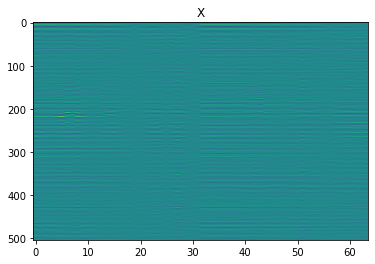

Text(0.5, 1.0, 'Y')

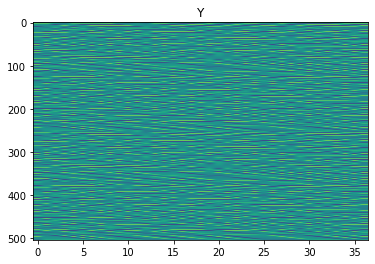

In [37]:
# load S3 -- high perf subject
subj='s3'
files = [ f for f in dataset_files if re.search(subj,f)]
X,oY,coords = dataset_loader(files[-1])
fs=coords[1]['fs']
ch_names=coords[-1]['coords']
# output is: X=eeg, Y=stimulus, coords=meta-info about dimensions of X and Y
print("EEG: X({}){} @{}Hz".format([c['name'] for c in coords],X.shape,coords[1]['fs']))                            
print("STIMULUS: Y({}){}".format([c['name'] for c in coords[:-1]]+['output'],oY.shape))
plt.imshow(X[0,:,:],aspect='auto');plt.title('X');plt.show()
plt.imshow(oY[0,:,:],aspect='auto');plt.title('Y')

Y_true=(36, 504, 1, 2)


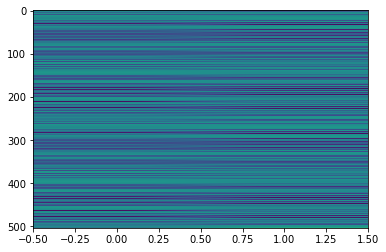

In [38]:
# get the true-label and convert to brain-response
from stim2event import stim2event
# map to event sequence, for rising/falling edges
evtlabs=('re','fe')
Y = stim2event(oY,evtypes=evtlabs,axis=-2) # (tr,samp,nY,e)
# extract the true target to fit to, using horible slicing trick
Y_true = Y[..., 0:1, :] #  (tr,samp,1,e)
print("Y_true={}".format(Y_true.shape))
plt.imshow(Y_true[0,:,0,:],aspect='auto')

Cxx=(64, 64)
Cxy=(1, 2, 27, 64)
Cyy=(1, 2, 27, 2, 27)


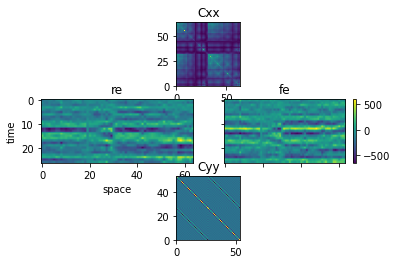

In [56]:
# get the summary statistics
from updateSummaryStatistics import updateSummaryStatistics, plot_summary_statistics
tau = 450 * fs // 1000 # ms->samples
Cxx, Cxy, Cyy = updateSummaryStatistics(X, Y_true, tau=tau)
print("Cxx={}".format(Cxx.shape))
print("Cxy={}".format(Cxy.shape))
print("Cyy={}".format(Cyy.shape))
plot_summary_statistics(Cxx, Cxy, Cyy, evtlabs=evtlabs, fs=fs, ch_names=ch_names)

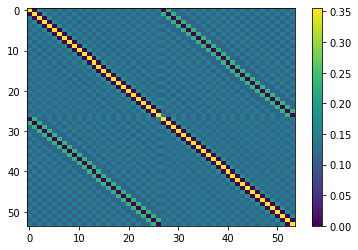

In [162]:
plt.imshow(Cyy.reshape((Cyy.shape[1]*Cyy.shape[2],-1)),aspect='auto');plt.colorbar()

trying to get pos from cap file!
A=(1, 64) R=(1, 2, 27)


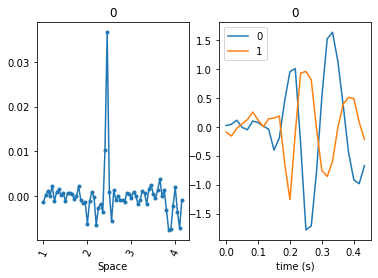

Int Lens:..............................

            IntLen    67   134   184   252   319   369   436   504 
              Perr  0.58  0.25  0.22  0.11  0.08  0.06  0.08  0.06   AUDC 23.4
         Perr(est)  0.55  0.35  0.27  0.20  0.16  0.13  0.12  0.10   PSAE 44.0
           StopErr  0.58  0.25  0.11  0.08  0.08  0.08  0.08  0.08   AUSC 21.0
     StopThresh(P)  0.62  0.33  0.17  0.12  0.10  0.10  0.10  0.10   SSAE 23.5



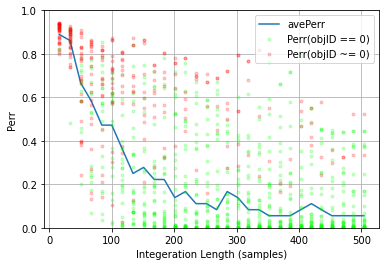

In [165]:
from multipleCCA import multipleCCA, robust_whitener
from updateSummaryStatistics import plot_factoredmodel
# run and plot the normal CCA model
J, W, R = multipleCCA(Cxx, Cxy, Cyy, reg=.02, rank=1)
plot_factoredmodel(W, R, ch_names=ch_names, fs=fs);plt.show()
# eval this models performance
from scoreStimulus import scoreStimulus
Fe = scoreStimulus(X, W, R)
from scoreOutput import scoreOutput
Fy = scoreOutput(Fe, Y, R) # (nM,nTrl,nEp,nY)
from decodingCurveSupervised import decodingCurveSupervised, plot_decoding_curve
dc=decodingCurveSupervised(Fy)
plot_decoding_curve(*dc)

In [ ]:
# Now try with the tensor factored version..

Text(0.5, 1.0, 'Whitened: Cxx')

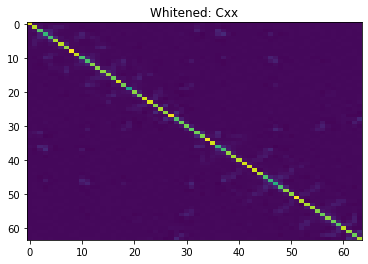

In [166]:
# 1. X spatial whitener
from multipleCCA import robust_whitener
Wx, iWx = robust_whitener(Cxx,reg=.02)

wCxxw = np.einsum("de,df,eg",Cxx,Wx,Wx)
plt.imshow(wCxxw,aspect='auto');plt.title('Whitened: Cxx')

In [172]:
# 2.Cyy combined whitener..
#  Cyy = (nM,e,tau,e,tau)
Wy, iWy = robust_whitener(Cyy.reshape((Cyy.shape[1]*Cyy.shape[2],-1)),reg=.02) # (e*tau,e*tau)
Wy = Wy.reshape(Cyy.shape[1:]) # (e,tau,e,tau)
iWy = iWy.reshape(Cyy.shape[1:]) # (e,tau,e,tau)

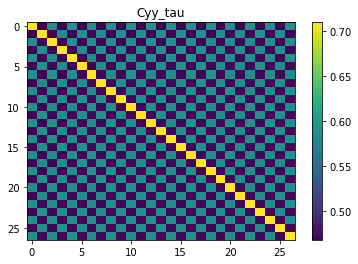

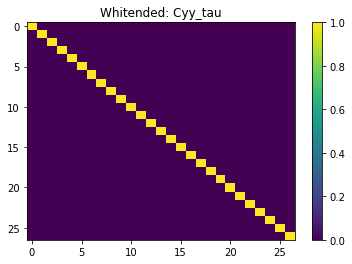

Text(0.5, 1.0, 'Tau Whitened: Cyy')

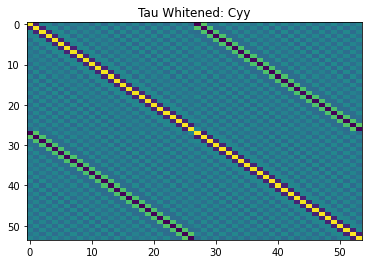

In [168]:
# 2. Y temporal whitener
#  Cyy = (nM,e,tau,e,tau)
Cyy_tau = np.sum(Cyy,axis=(0,1,3))
plt.imshow(Cyy_tau,aspect='auto');plt.title('Cyy_tau');plt.colorbar();plt.show()
Wy_tau, iWy_tau = robust_whitener(Cyy_tau,reg=.0)

wtauCyy_tauwtau = np.einsum("tu,tv,uw",Cyy_tau,Wy_tau,Wy_tau)
plt.imshow(wtauCyy_tauwtau,aspect='auto');plt.title('Whitended: Cyy_tau');plt.colorbar();plt.show()

wtauCyywtau = np.einsum("metfu,tv,uw->mevfw",Cyy,Wy_tau,Wy_tau)
plt.imshow(wtauCyywtau.reshape((Cyy.shape[1]*Cyy.shape[2],-1)),aspect='auto');plt.title('Tau Whitened: Cyy')

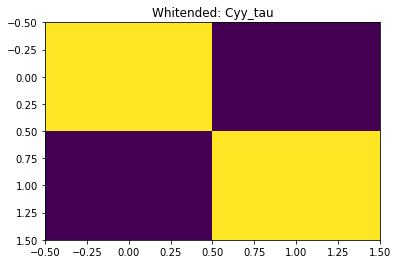

Text(0.5, 1.0, 'Tau Whitened: Cyy')

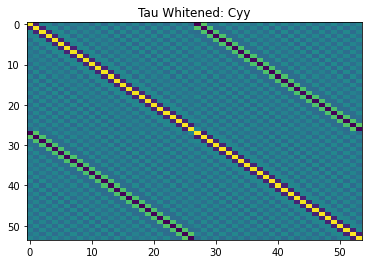

In [73]:
# 2. Y event whitener
#  Cyy = (nM,e,tau,e,tau)
Cyy_e = np.sum(Cyy,axis=(0,2,4))
Wy_e, iWy_e = robust_whitener(Cyy_e,reg=.02)


weCyy_ewe = np.einsum("ed,ef,dg",Cyy_e,Wy_e,Wy_e)
plt.imshow(weCyy_ewe,aspect='auto');plt.title('Whitended: Cyy_tau');plt.show()

wtauCyywtau = np.einsum("metfu,tv,uw->mevfw",Cyy,Wy_tau,Wy_tau)
plt.imshow(wtauCyywtau.reshape((Cyy.shape[1]*Cyy.shape[2],-1)),aspect='auto');plt.title('Tau Whitened: Cyy')

In [178]:
# apply the index specific whiteners
WxCxy = np.einsum("metd,df->metf",Cxy,Wx)
WeWy_tauWy_eCxy = np.einsum("metd,df,tu,eg->mguf",Cxy,Wx,Wy_tau,Wy_e)
print("WeWytWyeCxy {}".format(WeWy_tauWy_eCxy.shape))

WeWytWyeCxy (1, 2, 27, 64)


In [179]:
# CD/PARAFAC decomp
from tensorly.decomposition import parafac
#ten = WeWy_tauWy_eCxy[0,...]
#ten = Cxy[0,...]
ten = WxCxy[0,...]
kruskal_decomp = parafac(ten, rank=2, normalize_factors=True)
weight = kruskal_decomp[0]
factors = kruskal_decomp[1]
We = factors[0]
Wt = factors[1]
Wd = factors[2]
print("w={}".format(weight))

# check the reconstruction error
from tensorly import kruskal_to_tensor
recons = kruskal_to_tensor(kruskal_decomp)
print('recons={}'.format(recons.shape))
normW = np.sum(np.abs(ten.ravel()))
normRecons = np.sum(np.abs(recons.ravel()))
err = np.sum(np.abs(ten.ravel()-recons.ravel()))
print('Error: |W|={} |parafac|={} |err|={}'.format(normW,normRecons,err))

w=[71.07234309 53.02480758]
recons=(2, 27, 64)
Error: |W|=6328.651981863808 |parafac|=2619.3933023641116 |err|=5405.2196769632


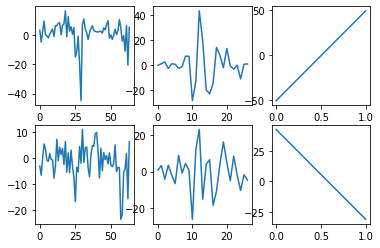

In [180]:
# plot the decomp: e,t,d x rank
rank=We.shape[1]
for r in range(rank):
    plt.subplot(rank,3,r*3+1); plt.plot(Wd[:,r]*weight[r])
    plt.subplot(rank,3,r*3+2); plt.plot(Wt[:,r]*weight[r])
    plt.subplot(rank,3,r*3+3); plt.plot(We[:,r]*weight[r])
    

recons=(2, 27, 64)
Error: |W|=10650.108572649195 |parafac|=5226.136134052549 |err|=8545.402965365256


In [158]:
# Combine with the whitener's to get methods to apply to raw data.
Wd = iWx @ Wd # (d,rank)
Wt = iWy_tau @ Wt # (tau,rank)
We = iWy_e @ We # (e,rank)

trying to get pos from cap file!
A=(2, 64) R=(2, 2, 27)


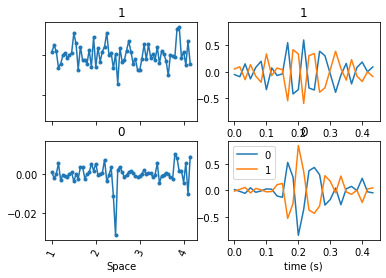

In [169]:
# make equivalent to the multiCCA outputs (so can re-use apply methods)
W = Wd.T # (rank,d)
R = np.einsum("tk,ek->ket",Wt,We) # (rank,e,tau)
plot_factoredmodel(W, R, ch_names=ch_names, fs=fs);plt.show()
# apply to data to test decoding


Int Lens:..............................

            IntLen    67   134   184   252   319   369   436   504 
              Perr  0.64  0.56  0.33  0.22  0.17  0.14  0.14  0.14   AUDC 33.5
         Perr(est)  0.51  0.38  0.29  0.21  0.17  0.14  0.11  0.09   PSAE 16.9
           StopErr  0.61  0.53  0.36  0.28  0.17  0.17  0.17  0.17   AUSC 34.1
     StopThresh(P)  0.39  0.22  0.15  0.12  0.09  0.09  0.09  0.09   SSAE 45.0



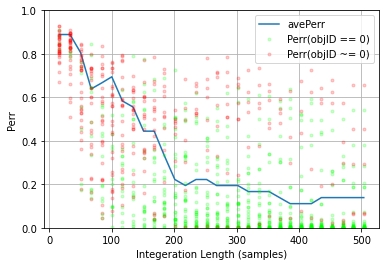

In [160]:
# apply to the data
from scoreStimulus import scoreStimulus
Fe = scoreStimulus(X, W, R)
from scoreOutput import scoreOutput
Fy = scoreOutput(Fe, Y, R) # (nM,nTrl,nEp,nY)
from decodingCurveSupervised import decodingCurveSupervised, plot_decoding_curve
dc=decodingCurveSupervised(Fy)
plot_decoding_curve(*dc)